In [1]:
!apt-get install -y libspatialindex-dev
!pip install geopandas folium mapclassify
!pip install prophet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 0s (1,546 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap, HeatMapWithTime, MarkerCluster
import json
import warnings
from IPython.display import display

# Optional: suppress common geometry warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('seaborn-v0_8-whitegrid')

df = pd.read_csv('berlin_crimes.csv')

In [3]:
# Data Cleaning and Preprocessing

print("--- Initial Info ---")
df.info()
print("\n--- Null Values ---")
print(df.isnull().sum())
print("\n--- Duplicated Rows ---")
print(f"Number of duplicated rows: {df.duplicated().sum()}")
# df = df.drop_duplicates() # Uncomment if duplicates are found and should be removed
print(df.dtypes)

# Check for inconsistencies in categorical columns like 'District' and 'Location'
print("\n--- Unique Districts ---")
print(sorted(df['District'].unique()))
print("\n--- Unique Locations (Sample) ---")
print(df['Location'].nunique())
print(df['Location'].unique()[:20])
df['District'] = df['District'].str.strip()
df['Location'] = df['Location'].str.strip()

# Check the 'Code' column - seems like a location identifier (LOR?)
print("\n--- Unique Codes (Sample) ---")
print(df['Code'].nunique())
print(df['Code'].unique()[:20])
# Check if Code uniquely identifies Location (mostly - except for Bezirk summary rows)
code_location_check = df.groupby('Code')['Location'].nunique()
print("\n--- Locations per Code ---")
print(code_location_check[code_location_check > 1]) # Should ideally be empty or only contain Bezirk summary codes

# Handle the 'Bezirk ..., nicht zuzuordnen' rows if necessary.
# Option 1: Keep them for Bezirk-level analysis but exclude from location-specific mapping/analysis.
# Option 2: Remove them if focusing solely on mapped locations.
df_mapped = df[~df['Location'].str.contains("nicht zuzuordnen", na=False)].copy()
print(f"\nOriginal df shape: {df.shape}")
print(f"Shape after removing 'nicht zuzuordnen': {df_mapped.shape}")

--- Initial Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Year                      1200 non-null   int64 
 1   District                  1200 non-null   object
 2   Code                      1200 non-null   int64 
 3   Location                  1200 non-null   object
 4   Robbery_Indoors           1200 non-null   int64 
 5   Street_Robbery            1200 non-null   int64 
 6   Simple_Assault            1200 non-null   int64 
 7   Aggravated_Assault        1200 non-null   int64 
 8   Threat                    1200 non-null   int64 
 9   Theft                     1200 non-null   int64 
 10  Motor_Vehicle_Theft       1200 non-null   int64 
 11  Theft_From_Vehicle        1200 non-null   int64 
 12  Bicycle_Theft             1200 non-null   int64 
 13  Burglary                  1200 non-null   int64 
 14  Uni

In [4]:
# 3. Feature Engineering

# 3.1. Total Crime (Already done by user, ensure it uses the correct list)
crime_columns = [
    'Robbery_Indoors', 'Street_Robbery', 'Simple_Assault', 'Aggravated_Assault',
    'Threat', 'Theft', 'Motor_Vehicle_Theft', 'Theft_From_Vehicle',
    'Bicycle_Theft', 'Burglary', 'Unintentional_Fire', 'Arson',
    'Property_Damage', 'Graffiti', 'Drug_Offenses', 'Neighborhood_Disturbance'
]
# Check columns again (good practice)
missing_cols = [col for col in crime_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected crime columns: {missing_cols}")

df['Total_Crime'] = df[crime_columns].sum(axis=1)
df_mapped['Total_Crime'] = df_mapped[crime_columns].sum(axis=1)

# 3.2. Crime Categories (Example - adjust based on criminological sense)
df_mapped['Violent_Crime'] = df_mapped[['Robbery_Indoors', 'Street_Robbery', 'Simple_Assault', 'Aggravated_Assault', 'Threat']].sum(axis=1)
df_mapped['Property_Crime'] = df_mapped[['Theft', 'Motor_Vehicle_Theft', 'Theft_From_Vehicle', 'Bicycle_Theft', 'Burglary', 'Property_Damage', 'Graffiti']].sum(axis=1)
df_mapped['Drug_Related'] = df_mapped['Drug_Offenses'] # Assuming this is the main one
df_mapped['Other_Disturbance'] = df_mapped[['Unintentional_Fire', 'Arson', 'Neighborhood_Disturbance']].sum(axis=1)

category_columns = ['Violent_Crime', 'Property_Crime', 'Drug_Related', 'Other_Disturbance']

# 3.4 Temporal Features (Already have 'Year')

print("\n--- Engineered Features (Sample) ---")
print(df_mapped[['Year', 'District', 'Location', 'Total_Crime'] + category_columns].head())


--- Engineered Features (Sample) ---
   Year District           Location  Total_Crime  Violent_Crime  \
0  2012    Mitte     Tiergarten Süd         5333           1014   
1  2012    Mitte  Regierungsviertel         6046            833   
2  2012    Mitte     Alexanderplatz        19314           2677   
3  2012    Mitte  Brunnenstraße Süd         4712            457   
4  2012    Mitte        Moabit West         6960           1194   

   Property_Crime  Drug_Related  Other_Disturbance  
0            3096           171               1052  
1            4231            98                884  
2           13018           435               3184  
3            3271           213                771  
4            4040           259               1467  


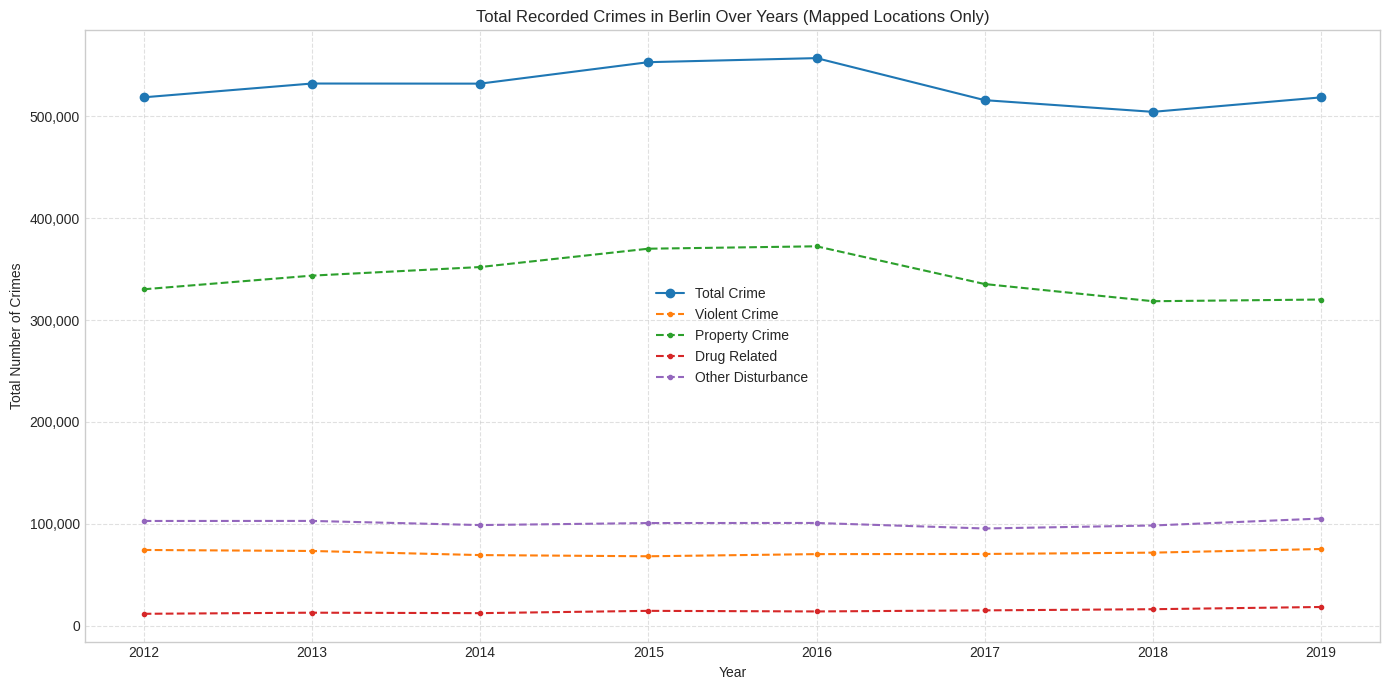

In [5]:
# 4.1. Overall Trends (Review/Enhance User's Plots)

# User's Plot 1: Overall Trend
yearly_crime_total = df_mapped.groupby('Year')['Total_Crime'].sum().reset_index()
yearly_crime_cats = df_mapped.groupby('Year')[category_columns].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(yearly_crime_total['Year'], yearly_crime_total['Total_Crime'], marker='o', linestyle='-', label='Total Crime')
# Add lines for categories
for cat in category_columns:
    plt.plot(yearly_crime_cats['Year'], yearly_crime_cats[cat], marker='.', linestyle='--', label=cat.replace('_', ' '))

plt.title('Total Recorded Crimes in Berlin Over Years (Mapped Locations Only)')
plt.xlabel('Year')
plt.ylabel('Total Number of Crimes')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(yearly_crime_total['Year'])
# Format Y-axis to be more readable
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

<ipython-input-6-5f4285128028>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=district_avg_crime, x='District', y='Total_Crime', palette='viridis')


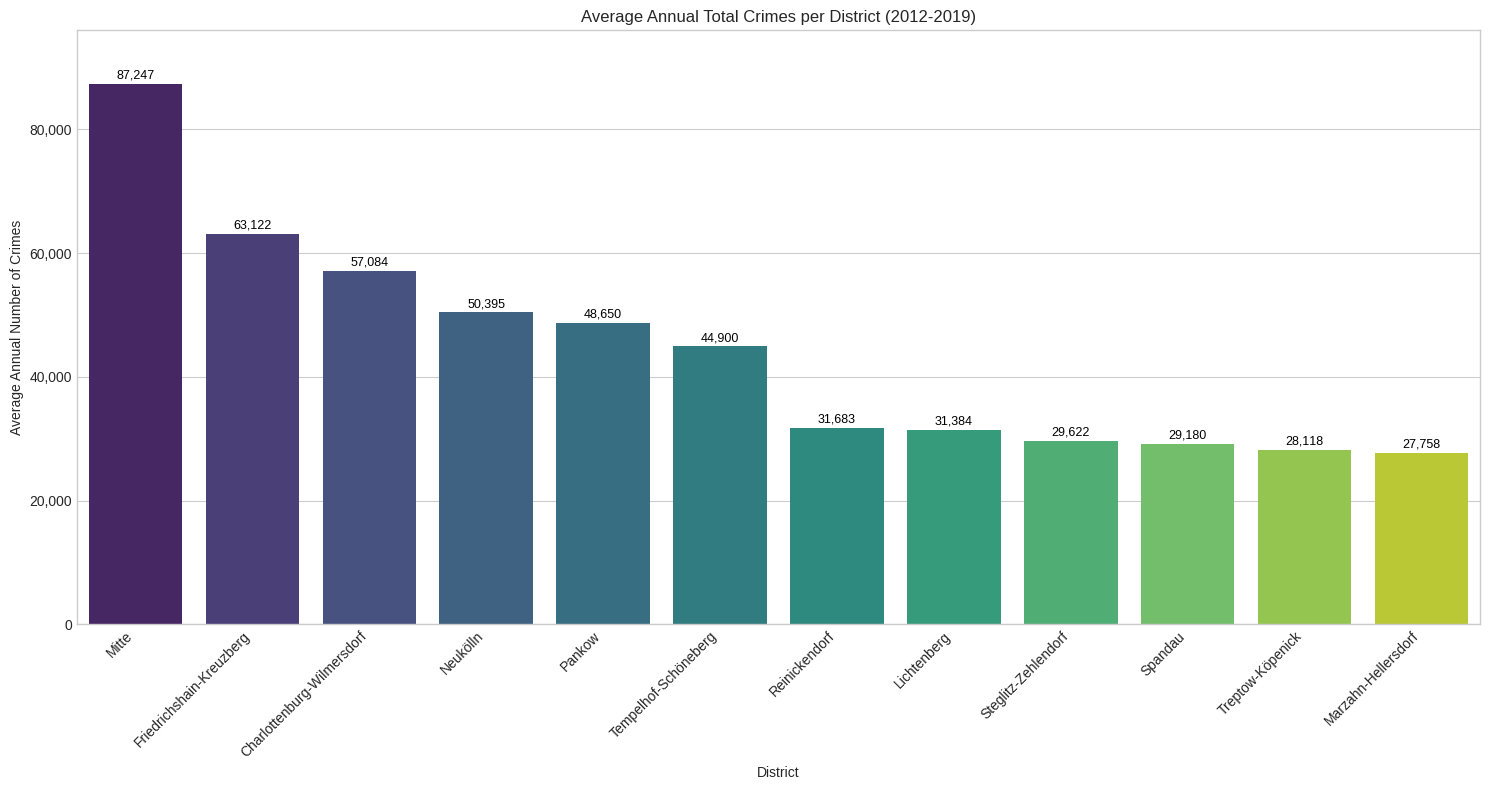

In [6]:
# 4.2. District Level Analysis (Review/Enhance User's Plots)

# User's Plot 2: Crime per District
# Calculate average annual crime per district for better comparison
district_avg_crime = df_mapped.groupby('District')['Total_Crime'].sum() / df_mapped['Year'].nunique()
district_avg_crime = district_avg_crime.sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 8))
barplot = sns.barplot(data=district_avg_crime, x='District', y='Total_Crime', palette='viridis')
plt.title('Average Annual Total Crimes per District (2012-2019)')
plt.xlabel('District')
plt.ylabel('Average Annual Number of Crimes')
plt.xticks(rotation=45, ha='right')
# Add text labels
for index, row in district_avg_crime.iterrows():
    barplot.text(index, row.Total_Crime + (district_avg_crime['Total_Crime'].max() * 0.01),
                 f'{row.Total_Crime:,.0f}',
                 color='black', ha="center", fontsize=9)
plt.ylim(0, district_avg_crime['Total_Crime'].max() * 1.1)
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

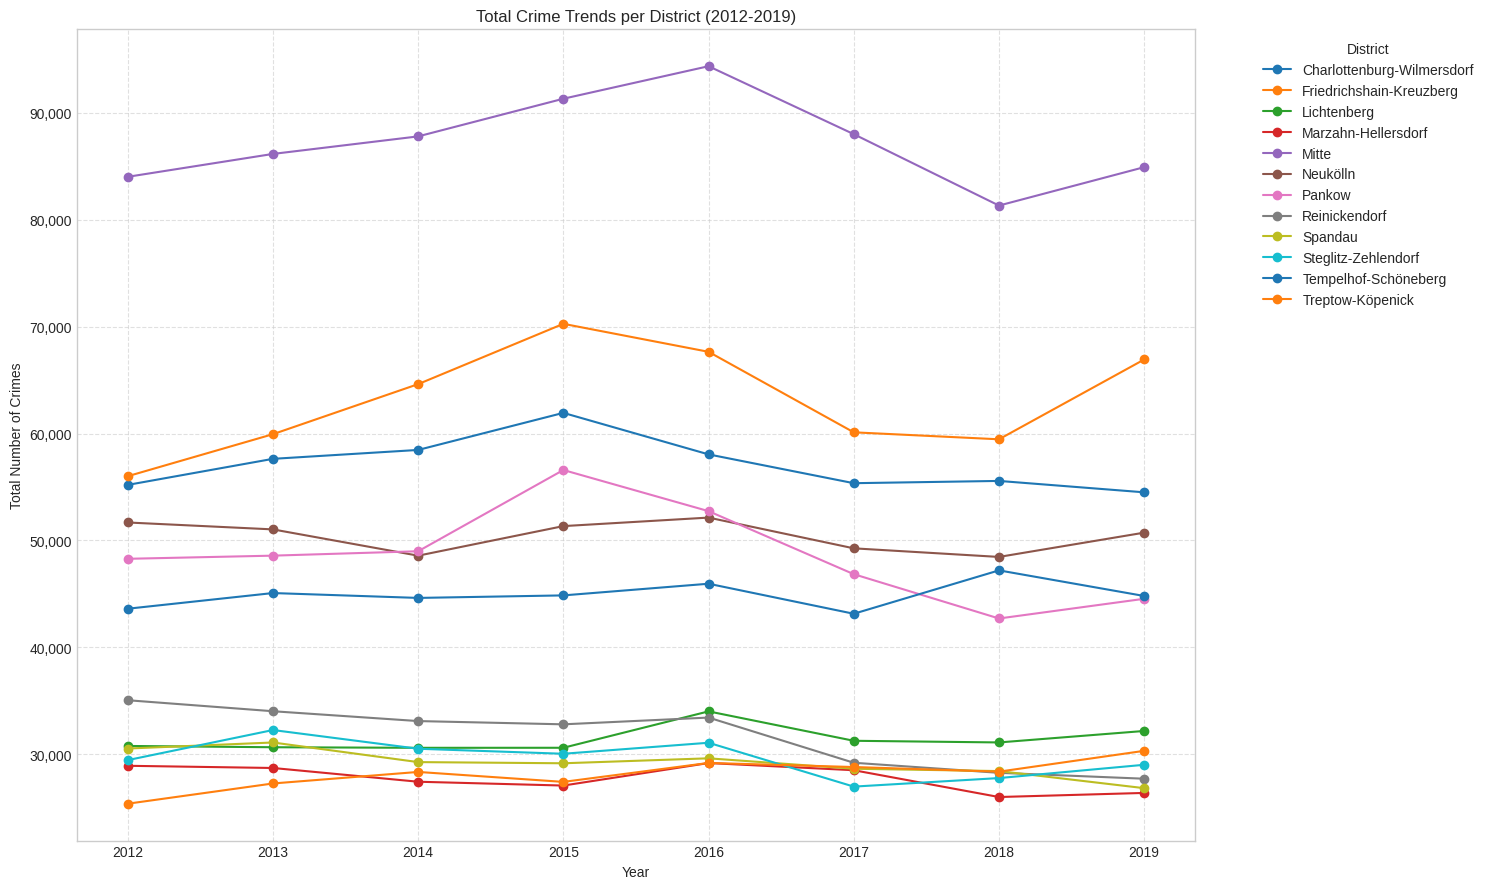

In [7]:
district_yearly_crime = df_mapped.groupby(['Year', 'District'])['Total_Crime'].sum().unstack()

plt.figure(figsize=(15, 9))
for district in district_yearly_crime.columns:
    plt.plot(district_yearly_crime.index, district_yearly_crime[district], marker='o', linestyle='-', label=district)

plt.title('Total Crime Trends per District (2012-2019)')
plt.xlabel('Year')
plt.ylabel('Total Number of Crimes')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(district_yearly_crime.index)
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.subplots_adjust(right=0.8) # Adjust layout to make space for legend
plt.show()

<ipython-input-8-690abcd02a4d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot_types = sns.barplot(x=crime_type_totals.index, y=crime_type_totals.values, palette='magma')


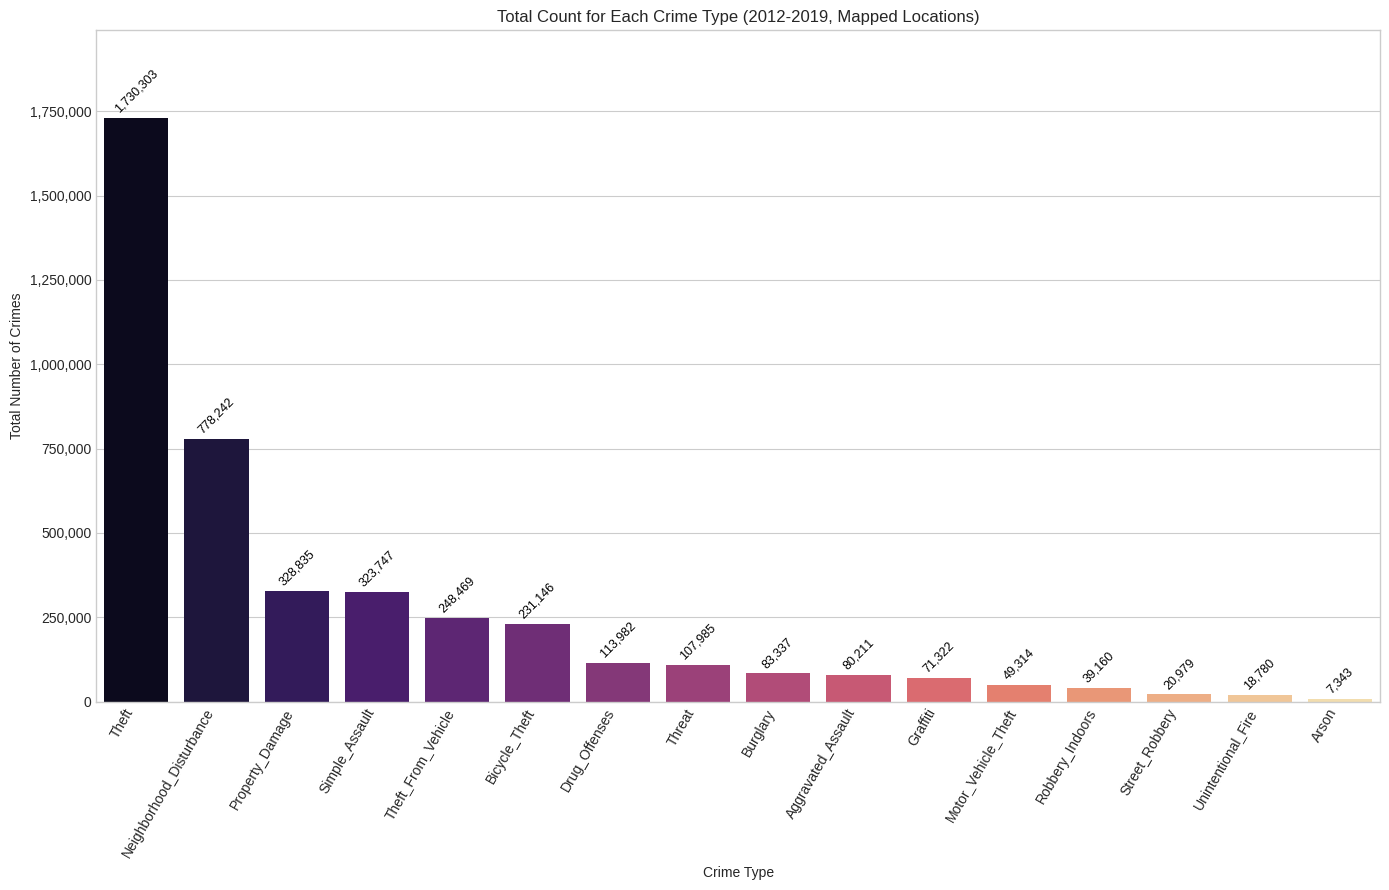

In [8]:
# 4.3. Crime Type Analysis (Review/Enhance User's Plots)

# User's Plot 3: Crime Type Prevalence
crime_type_totals = df_mapped[crime_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 9))
barplot_types = sns.barplot(x=crime_type_totals.index, y=crime_type_totals.values, palette='magma')
plt.title('Total Count for Each Crime Type (2012-2019, Mapped Locations)')
plt.xlabel('Crime Type')
plt.ylabel('Total Number of Crimes')
plt.xticks(rotation=60, ha='right') # Increased rotation for readability
# Add text labels
for i, v in enumerate(crime_type_totals.values):
    barplot_types.text(i, v + (crime_type_totals.max() * 0.01),
                       f'{v:,.0f}',
                       color='black', ha="center", fontsize=9, rotation=45) # Rotate text slightly
plt.ylim(0, crime_type_totals.max() * 1.15) # Adjust ylim slightly
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

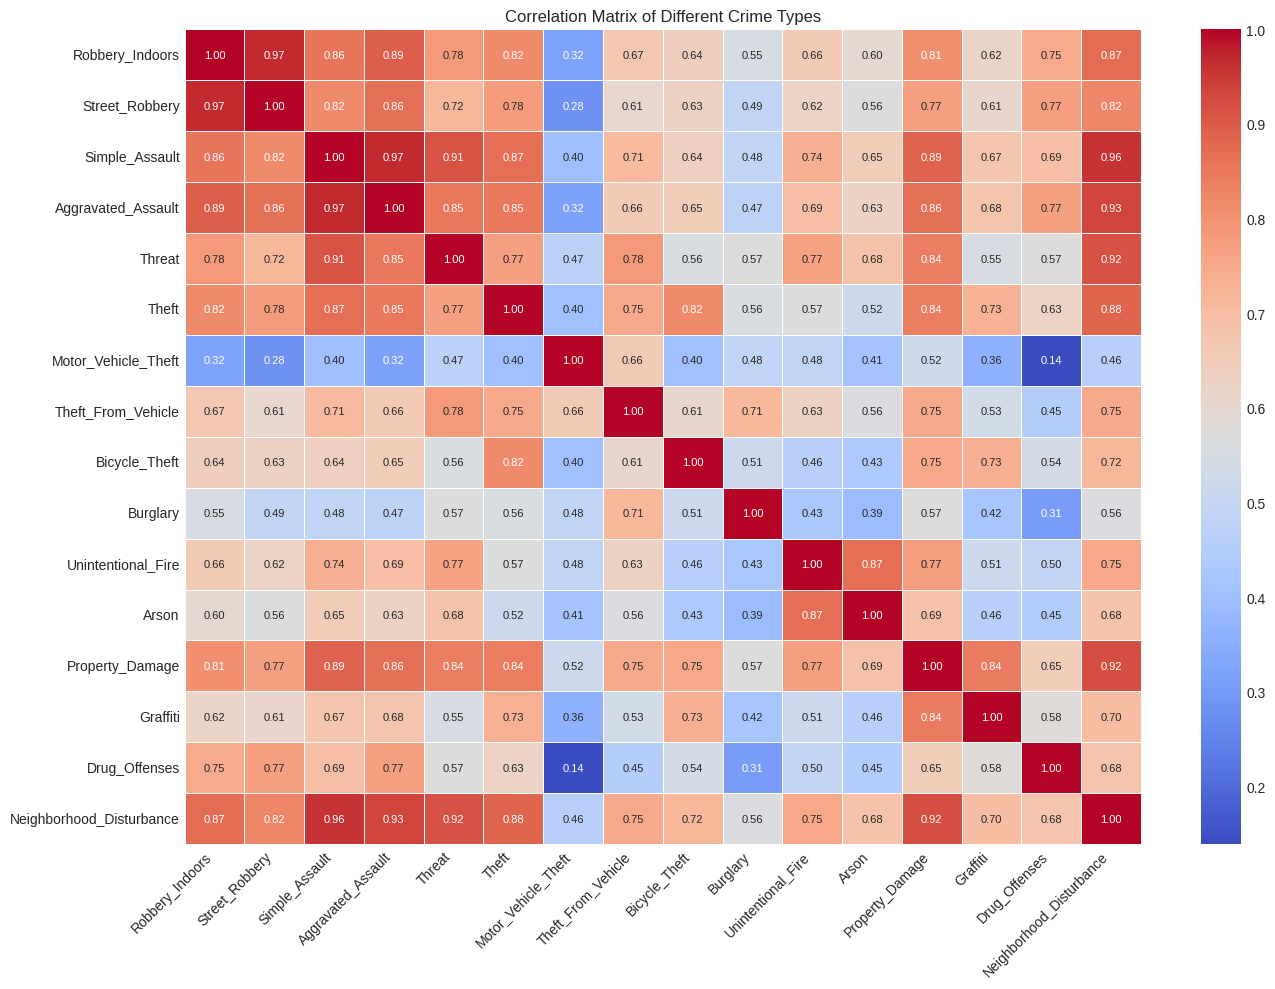


--- Top 20 Locations by Average Annual Crime ---
                      District                  Location   Code  Total_Crime
0                        Mitte            Alexanderplatz  10113    20793.875
1     Friedrichshain-Kreuzberg      Tempelhofer Vorstadt  20202    12955.125
2     Friedrichshain-Kreuzberg  Frankfurter Allee Süd FK  20508    11738.000
3         Tempelhof-Schöneberg           Schöneberg-Nord  70101    10989.375
4                        Mitte           Wedding Zentrum  10442    10206.250
5                     Neukölln  Neuköllner Mitte/Zentrum  80102     9793.500
6     Friedrichshain-Kreuzberg   Südliche Friedrichstadt  20101     9531.500
7         Tempelhof-Schöneberg                 Tempelhof  70404     9459.000
8   Charlottenburg-Wilmersdorf            Kurfürstendamm  40309     8723.500
9                        Mitte                Moabit Ost  10222     8045.250
10                       Mitte             Osloer Straße  10331     7897.000
11                       M

In [9]:
# Correlation between Crime Types
plt.figure(figsize=(14, 10))
correlation_matrix = df_mapped[crime_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of Different Crime Types')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Markdown Cell: Discuss strong positive/negative correlations found.

# 4.4. Location Level Analysis (Highest Crime Locations)
# Average annual crime per location
location_avg_crime = df_mapped.groupby(['District', 'Location', 'Code'])['Total_Crime'].sum() / df_mapped['Year'].nunique()
location_avg_crime = location_avg_crime.sort_values(ascending=False).reset_index()

print("\n--- Top 20 Locations by Average Annual Crime ---")
print(location_avg_crime.head(20))

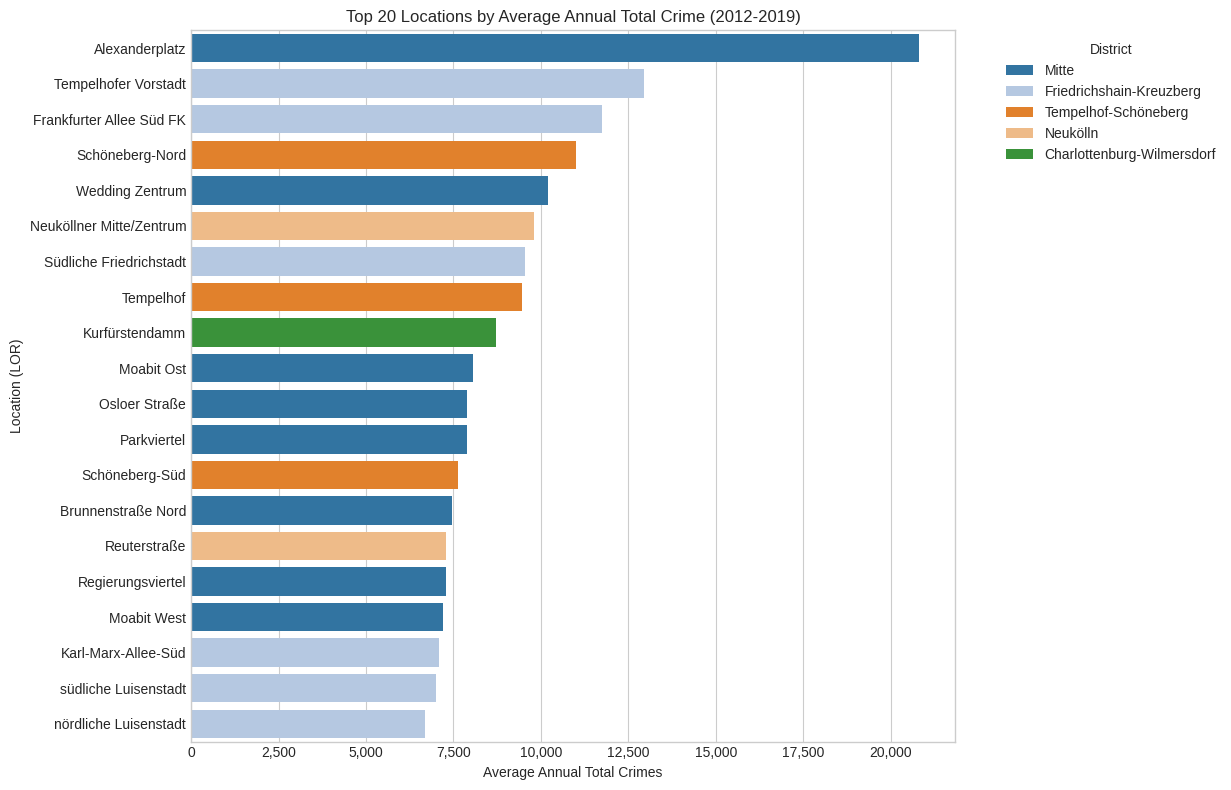

In [10]:
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(data=location_avg_crime.head(top_n), y='Location', x='Total_Crime', hue='District', palette='tab20', dodge=False)
plt.title(f'Top {top_n} Locations by Average Annual Total Crime (2012-2019)')
plt.xlabel('Average Annual Total Crimes')
plt.ylabel('Location (LOR)')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.subplots_adjust(right=0.8) # Adjust layout
plt.show()

In [11]:
# Define file paths
geo_file_path = 'berlin_lor.geojson'  # Adjust as needed
crime_df = df_mapped.copy()           # Assuming df_mapped is your cleaned crime DataFrame
# Load and inspect GeoData
gdf = gpd.read_file(geo_file_path)
print("GeoData loaded:", gdf.shape)
print(gdf[['SCHLUESSEL', 'BZR_NAME']].head())

# Check and convert CRS to WGS84 (lat/lon) for mapping
gdf_wgs84 = gdf.to_crs('EPSG:4326')
# Standardize column names
geo_key_column = 'SCHLUESSEL'
crime_key_column = 'Code'

# Ensure keys are strings
gdf_wgs84[geo_key_column] = gdf_wgs84[geo_key_column].astype(str)
crime_df[crime_key_column] = crime_df[crime_key_column].astype(str)

# Fix 5-digit codes by prepending '0'
def normalize_code(code):
    if len(code) == 5:
        return '0' + code
    elif len(code) == 6:
        return code
    else:
        return None

crime_df['Matching_Key'] = crime_df[crime_key_column].apply(normalize_code)

# Handle nulls after conversion
nulls = crime_df['Matching_Key'].isnull().sum()
if nulls > 0:
    print(f"Warning: {nulls} codes could not be normalized.")

crime_agg = crime_df.groupby('Matching_Key')['Total_Crime'].sum().reset_index()
print("Crime aggregation complete:", crime_agg.shape)

merged_gdf = gdf_wgs84.merge(crime_agg, left_on=geo_key_column, right_on='Matching_Key', how='left')
merged_gdf['Total_Crime'] = merged_gdf['Total_Crime'].fillna(0)
print("Merged GeoData:", merged_gdf.shape)



GeoData loaded: (138, 3)
  SCHLUESSEL           BZR_NAME
0     010111     Tiergarten Süd
1     010112  Regierungsviertel
2     010113     Alexanderplatz
3     010114    Brunnenstr. Süd
4     010221        Moabit West
Crime aggregation complete: (138, 2)
Merged GeoData: (138, 5)


In [12]:
# Center on Berlin
berlin_center = [52.52, 13.405]
m_choropleth = folium.Map(location=berlin_center, zoom_start=10, tiles='CartoDB positron')

# Add Choropleth
folium.Choropleth(
    geo_data=merged_gdf,
    name='Choropleth',
    data=merged_gdf,
    columns=[geo_key_column, 'Total_Crime'],
    key_on=f'feature.properties.{geo_key_column}',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Crime Count (2012–2019)',
    nan_fill_color='gray'
).add_to(m_choropleth)

folium.LayerControl().add_to(m_choropleth)
display(m_choropleth)